Author: Shivani Bhatia

# **🚗 Problem Statement: Vehicle Speed Detection in CCTV Footage**  

### Overview  
Speeding vehicles are a major cause of road accidents and traffic violations. Traditional speed monitoring systems rely on radar guns or inductive loop sensors, which can be expensive and difficult to deploy in every location.  

### Objective  
This project aims to **automatically detect and estimate the speed of vehicles** from **CCTV surveillance footage** using **computer vision and deep learning**. By leveraging **YOLO for object detection** and **optical flow techniques for motion estimation**, the system provides a non-intrusive and scalable solution for traffic monitoring.  

### Key Challenges  
✅ **Real-time processing** – Detecting vehicles and estimating their speed with minimal delay.  
✅ **Varying conditions** – Handling different lighting, weather, and camera angles.  
✅ **Accuracy** – Ensuring precise speed estimation for potential law enforcement applications.  

### Expected Outcome  
A robust model capable of detecting vehicles and estimating their speed from video feeds, contributing to **smart city traffic management** and **road safety enforcement**. 🚦


# **📌 Summary of Steps**:

* 1️⃣ Load video, define reference lines & initialize dictionaries
* 2️⃣ Detect vehicles using YOLO/Object Detection Model
* 3️⃣ Track vehicles using an Object Tracker
* 4️⃣ Detect when a vehicle crosses the Red Line → Store timestamp
* 5️⃣ Detect when the same vehicle crosses the Blue Line → Compute speed
* 6️⃣ Draw bounding boxes & display speed
* 7️⃣ Save & show frames
* 8️⃣ Exit when video ends or user presses Esc

In [ ]:
!pip install keyboard
import keyboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.81-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [ ]:
import ultralytics
ultralytics.__version__

'8.3.81'

In [ ]:
import os
import time
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import*

model=YOLO('yolov8s.pt')

In [ ]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
              'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
tracker=Tracker()
count=0

In [ ]:
cap=cv2.VideoCapture('traffictrim.mp4')

In [ ]:
# prompt: find this highway.mp4 file
# If it's not, replace with the correct path
cap=cv2.VideoCapture('traffictrim.mp4')

if not cap.isOpened():
  print("Error: Could not open video file. Check the file path.")
else:
  print("Video file found.")

# proceed with the rest of your code...


Video file found.



0: 320x640 5 cars, 1 truck, 304.1ms
Speed: 3.7ms preprocess, 304.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


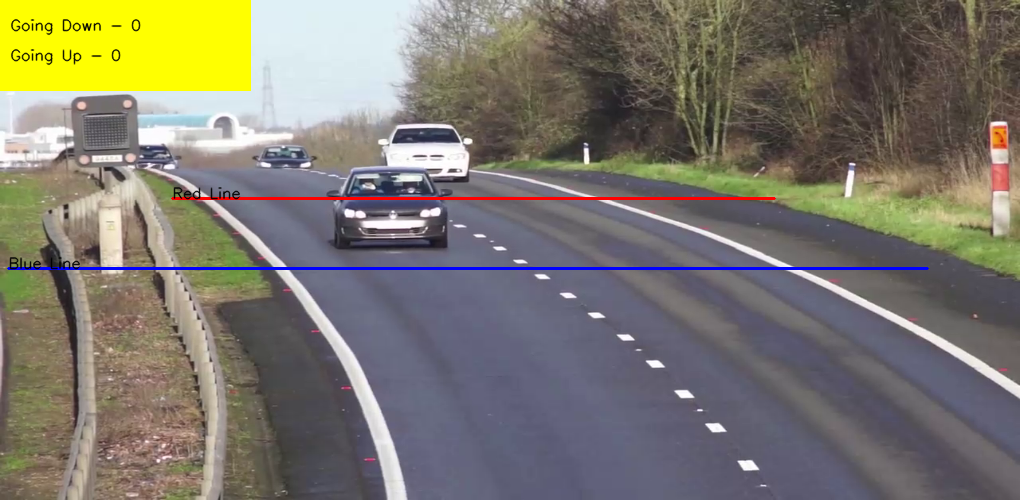

Press 'q' and Enter to stop: q
Manual Stop: 'q' key pressed.


In [ ]:
# Initialize dictionaries to track vehicle timestamps for crossing lines
down = {}  # Stores timestamps when vehicles cross the red line moving down
up = {}    # Stores timestamps when vehicles cross the blue line moving up

# Lists to keep track of unique vehicle IDs that have crossed the lines
counter_down = []  # Vehicles that moved downward
counter_up = []    # Vehicles that moved upward

# Define positions of the red and blue lines in the frame
red_line_y = 198
blue_line_y = 268
offset = 6  # Offset for detecting vehicle crossing

# Create a folder to save detected frames if it doesn't exist
if not os.path.exists('detected_frames'):
    os.makedirs('detected_frames')

# Define video codec and output video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # XVID codec for AVI format
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1020, 500))  # Output video file

# Start processing frames from the video
while True:
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        break  # Exit loop if no more frames

    count += 1
    # Uncomment below lines to process only alternate frames (to reduce processing load)
    # if count % 2 != 0:
    #     continue

    # Resize frame to a fixed size for consistency
    frame = cv2.resize(frame, (1020, 500))

    # Perform object detection using YOLO model
    results = model.predict(frame)
    a = results[0].boxes.data  # Extract detected bounding boxes
    a = a.detach().cpu().numpy()  # Convert to NumPy array
    px = pd.DataFrame(a).astype("float")  # Convert to pandas DataFrame

    list = []  # List to store bounding boxes of detected cars

    # Iterate through detected objects
    for index, row in px.iterrows():
        x1 = int(row[0])  # Bounding box top-left x-coordinate
        y1 = int(row[1])  # Bounding box top-left y-coordinate
        x2 = int(row[2])  # Bounding box bottom-right x-coordinate
        y2 = int(row[3])  # Bounding box bottom-right y-coordinate
        d = int(row[5])   # Class index of detected object
        c = class_list[d]  # Get class name from index

        # Only consider objects detected as 'car'
        if 'car' in c:
            list.append([x1, y1, x2, y2])

    # Update object tracker with detected bounding boxes
    bbox_id = tracker.update(list)

    # Process each tracked vehicle
    for bbox in bbox_id:
        x3, y3, x4, y4, id = bbox  # Bounding box coordinates and unique ID
        cx = int(x3 + x4) // 2  # Calculate center x-coordinate of vehicle
        cy = int(y3 + y4) // 2  # Calculate center y-coordinate of vehicle

        # Detect vehicles moving downward
        if red_line_y < (cy + offset) and red_line_y > (cy - offset):
            down[id] = time.time()  # Store timestamp when crossing red line

        if id in down:
            if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
                elapsed_time = time.time() - down[id]  # Time taken to cross from red to blue line

                if counter_down.count(id) == 0:  # Ensure each vehicle is counted once
                    counter_down.append(id)
                    distance = 10  # Distance between red and blue lines (meters)
                    a_speed_ms = distance / elapsed_time  # Speed in meters per second
                    a_speed_kh = a_speed_ms * 3.6  # Convert to km/h

                    # Draw visual elements on the frame
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)  # Mark vehicle center
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

        # Detect vehicles moving upward
        if blue_line_y < (cy + offset) and blue_line_y > (cy - offset):
            up[id] = time.time()  # Store timestamp when crossing blue line

        if id in up:
            if red_line_y < (cy + offset) and red_line_y > (cy - offset):
                elapsed1_time = time.time() - up[id]  # Time taken to cross from blue to red line

                if counter_up.count(id) == 0:  # Ensure each vehicle is counted once
                    counter_up.append(id)
                    distance1 = 10  # Distance between blue and red lines (meters)
                    a_speed_ms1 = distance1 / elapsed1_time  # Speed in meters per second
                    a_speed_kh1 = a_speed_ms1 * 3.6  # Convert to km/h

                    # Draw visual elements on the frame
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)  # Mark vehicle center
                    cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(frame, str(id), (x3, y3), cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
                    cv2.putText(frame, str(int(a_speed_kh1)) + 'Km/h', (x4, y4), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

    # Define colors for visual elements
    text_color = (0, 0, 0)  # Black color for text
    yellow_color = (0, 255, 255)  # Yellow color for background
    red_color = (0, 0, 255)  # Red color for lines
    blue_color = (255, 0, 0)  # Blue color for lines

    # Create a yellow rectangle at the top-left for displaying counts
    cv2.rectangle(frame, (0, 0), (250, 90), yellow_color, -1)

    # Draw red and blue lines on the frame
    cv2.line(frame, (172, 198), (774, 198), red_color, 2)
    cv2.putText(frame, 'Red Line', (172, 198), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    cv2.line(frame, (8, 268), (927, 268), blue_color, 2)
    cv2.putText(frame, 'Blue Line', (8, 268), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Display vehicle count
    cv2.putText(frame, 'Going Down - ' + str(len(counter_down)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'Going Up - ' + str(len(counter_up)), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

    # Save the processed frame
    frame_filename = f'detected_frames/frame_{count}.jpg'
    cv2.imwrite(frame_filename, frame)

    # Write the frame to output video
    out.write(frame)

    # Display the frame
    cv2_imshow(frame)  # Use cv2_imshow for displaying in Google Colab

    # Exit loop if 'Esc' key (27) is pressed
    if keyboard.is_pressed('esc'):
        print("Manual Stop: ESC key pressed.")
        break

# Release video objects and close windows
cap.release()
out.release()
cv2.destroyAllWindows()
